In [1]:
import io
import os
import re
import sys
import csv
import gzip
import time
import json
import pickle
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
from scipy.stats import pearsonr
# import sqlite3
# from PIL import Image
import matplotlib.pyplot as plt
# from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
# from collections import Counter
# import seaborn as sns
# import matplotlib.colors as mcolors
# from matplotlib.ticker import FuncFormatter
import itertools
import collections
import pyreadr
import psa
import pywfa
from IPython.display import display_html
# import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
from hla_phase_functions import *
from hla_align_functions import *

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None

# Genuine logics changed from the main script were marked by string **X** in the original R files.
# Simplicity changes were marked by string **Y**

<Figure size 100x100 with 0 Axes>

# OneKG

In [3]:
gene = 'DQB1'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3570/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')

ref_samples = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/oneKG.samples', sep = ' ')
hlatypes = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG_30x/oneKG.chr6.vcf.gz"
reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))

# subset_samples = None

return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information,
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            read_from_QUILT = False, 
                            subset_vcf_samples = None,
                            sample_linker = None)
plot_phase(return_dict, hlatypes, 0)

# individual = 'NA12878'
# ix = hlatypes.index[hlatypes['Sample ID'] == 'NA12878'][0]
# display_indices = np.arange(10)
# res = visualise_phase(gene, ix, hlatypes, return_dict)
# compare_phase(display_indices, res)

# reference_exclude_samplelist_file = ''
# if reference_exclude_samplelist_file != '':
#     samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)
# if samples_to_remove is not none, save to "hlauntyped.exclude.txt"

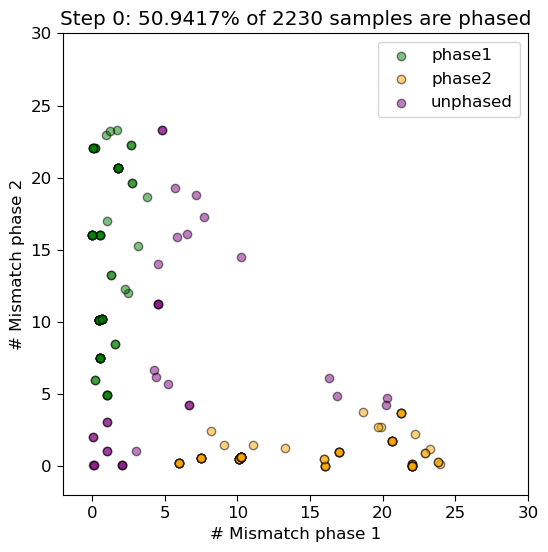

In [41]:
plot_phase(return_dict, 0, xlim = (-2,30))

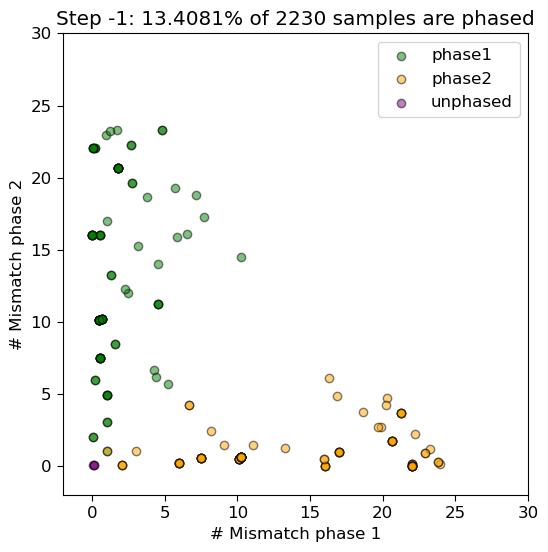

In [42]:
plot_phase(return_dict, -1, xlim = (-2,30))

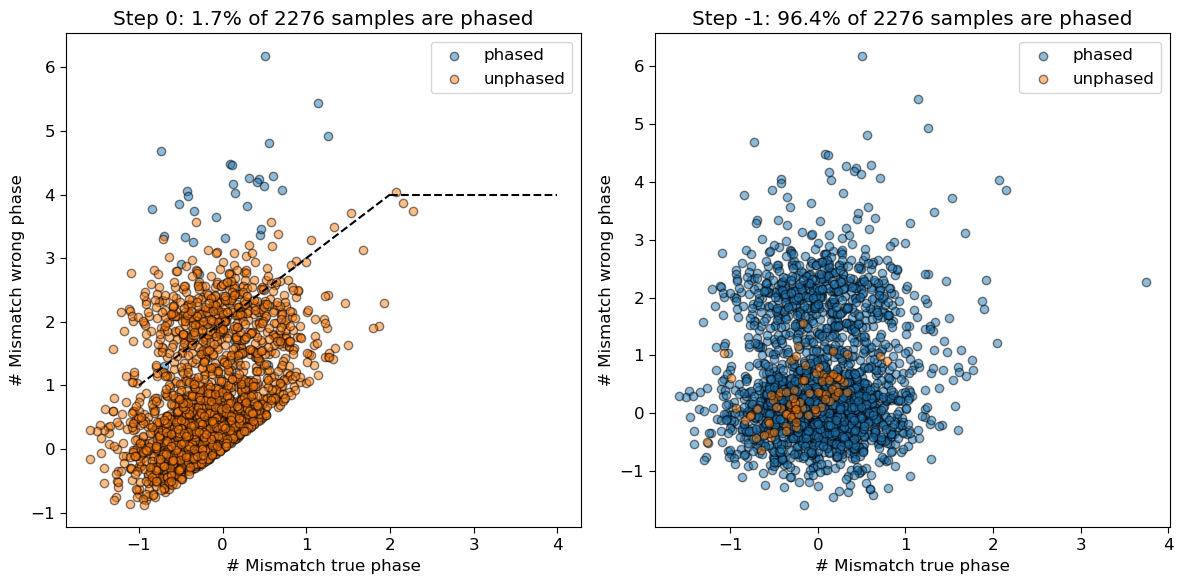

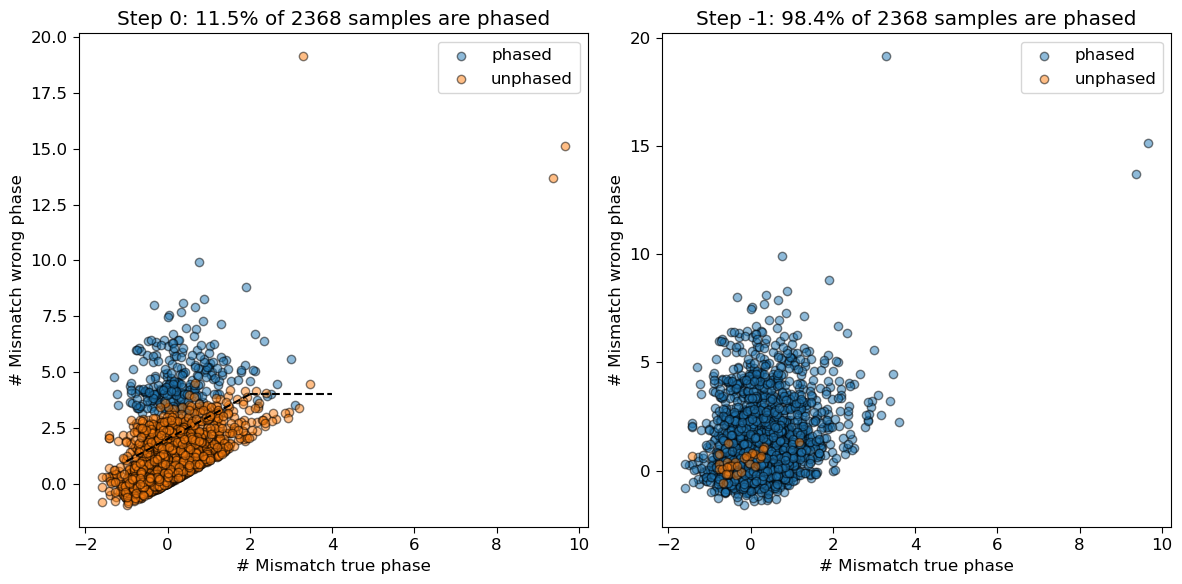

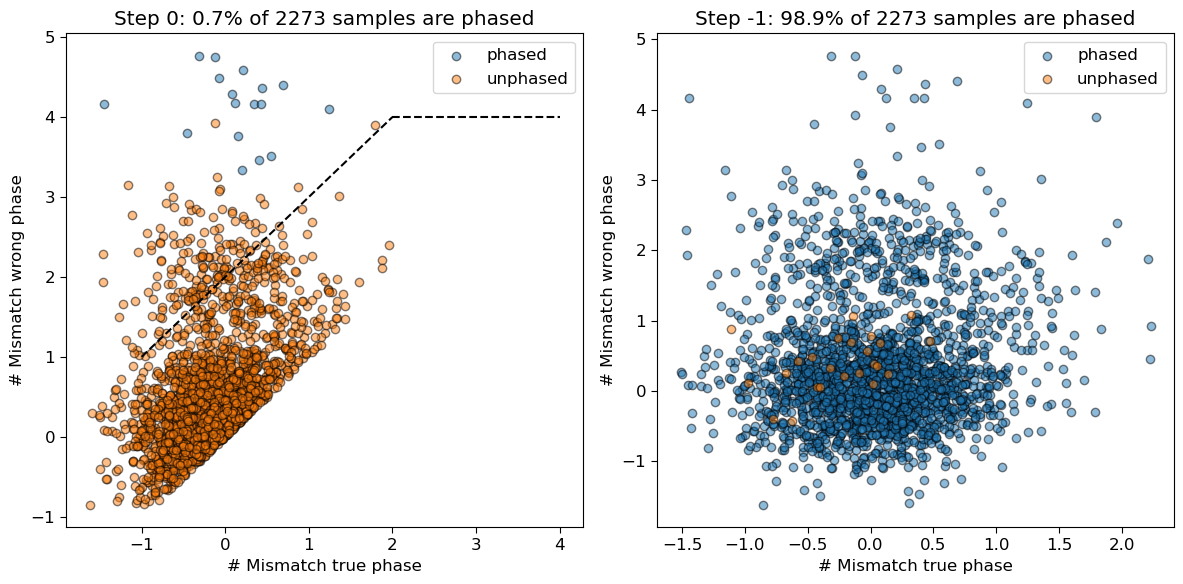

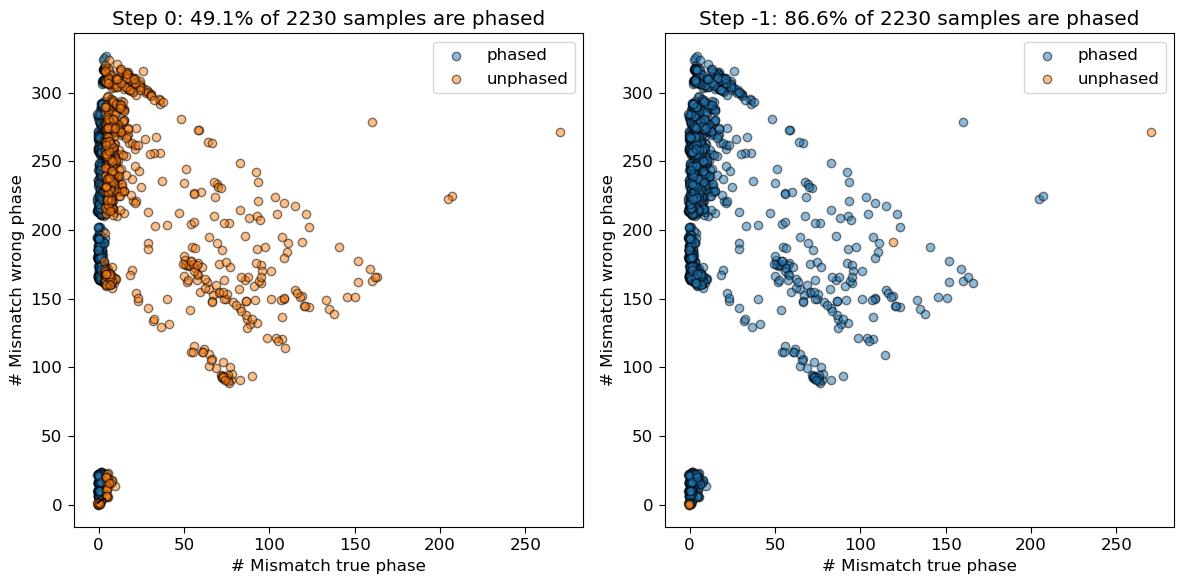

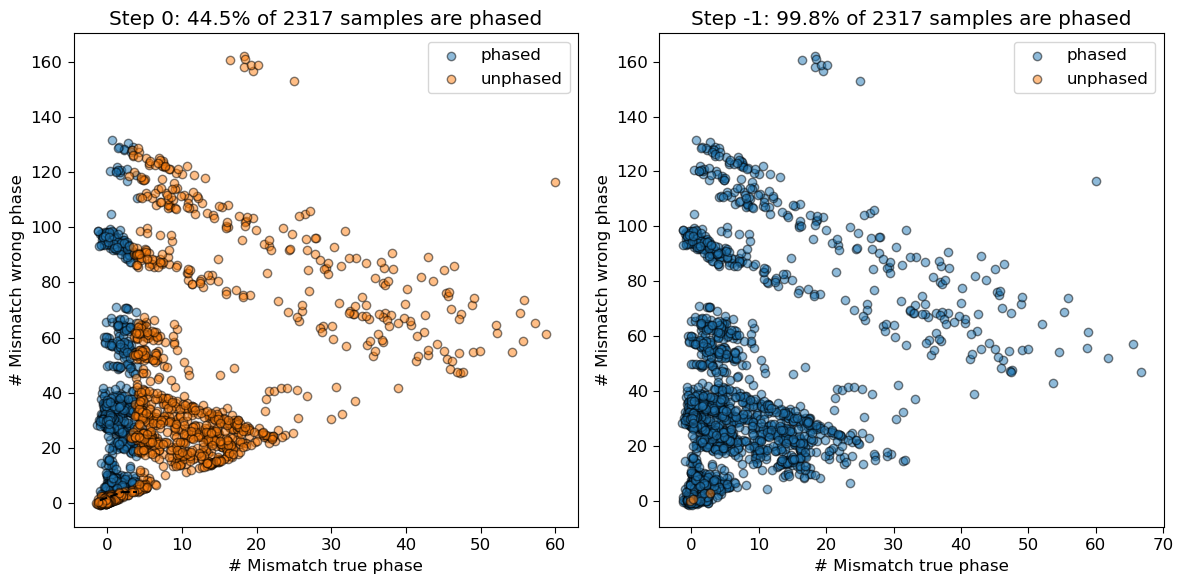

In [2]:
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3570/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')

ref_samples = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/oneKG.samples', sep = ' ')
hlatypes = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG_30x/oneKG.chr6.vcf.gz"
reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))

return_dict_ary = []
metrics = pd.DataFrame(columns = ['Gene', 'Length', 'n_SNP', 'n_heterozygous', 'n_phased'])
for gene in HLA_GENES:
    return_dict = phase_hla_on_haplotypes(gene = gene, 
                                ipd_gen_file_dir = ipd_gen_file_dir, 
                                hla_gene_information = hla_gene_information,
                                hlatypes = hlatypes,
                                phased_vcf = phased_vcf, 
                                reference_allele_ary = reference_allele_ary, 
                                read_from_QUILT = False, 
                                subset_vcf_samples = None,
                                sample_linker = None)
    return_dict_ary.append(return_dict)

    ix = hla_gene_information[hla_gene_information['Name'] == f'HLA-{gene}'].index[0]
    length = (hla_gene_information['End'] - hla_gene_information['Start']).loc[ix]
    n_snp = len(return_dict['merged_snps'])
    n_heterozygous = len(hlatypes[(hlatypes[f'HLA-{gene} 1'] != hlatypes[f'HLA-{gene} 2'])])
    n_phased = n_heterozygous-len(return_dict['unphased_df'])

    metrics.loc[len(metrics)] = [gene, length, n_snp, n_heterozygous, n_phased]
    
for gene, r in zip(HLA_GENES, return_dict_ary):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    plot_phase(r, 0, ax=axes[0], title = gene)
    plot_phase(r, -1, ax=axes[1], title = gene)

    plt.tight_layout()
    plt.show()

In [7]:
oldphase1, oldphase2, phased1, phased2 = return_dict['initial_phase_res']
phased1, phased2 = return_dict['phases_ary'][ix]

np.random.seed(42)
jitter1 = np.random.normal(loc=0, scale=0.5, size=len(phased1))
jitter2 = np.random.normal(loc=0, scale=0.5, size=len(phased1))
oldphase1 = oldphase1 + jitter1
oldphase2 = oldphase2 + jitter2

gene = return_dict['gene']
hlatypes = return_dict['hlatypes']
tmp = hlatypes[(hlatypes[f'HLA-{gene} 1'] != hlatypes[f'HLA-{gene} 2'])]

phase1_indices = np.intersect1d(np.where(phased1)[0], tmp.index)
phase2_indices = np.intersect1d(np.where(phased2)[0], tmp.index)
unphased_indices = np.intersect1d(np.where(~phased1 & ~phased2)[0], tmp.index)

swap_mask = oldphase1 > oldphase2
oldphase1_swapped = np.where(swap_mask, oldphase2, oldphase1)
oldphase2_swapped = np.where(swap_mask, oldphase1, oldphase2)

xmax1 = oldphase1_swapped[unphased_indices].max() if oldphase1_swapped.size > 0 else 0
xmax1 = 0
xmax2 = oldphase1[phase1_indices].max() if oldphase1.size > 0 else 0
xmax3 = oldphase2[phase2_indices].max() if oldphase2.size > 0 else 0
xmax = max(xmax1, xmax2, xmax3)

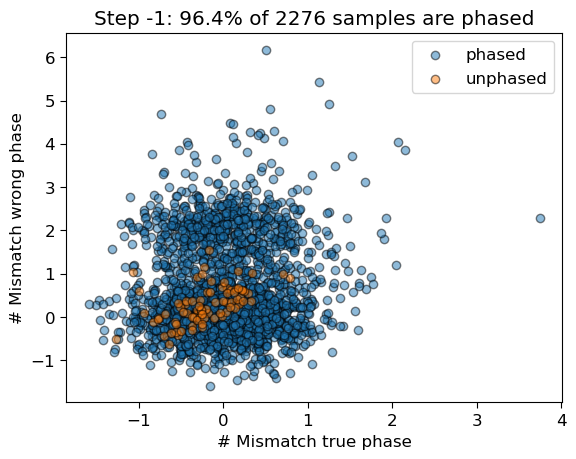

In [11]:
plot_phase(return_dict, -1, title = '', colors = CATEGORY_CMAP_HEX, ax = None)

# GAMCC

In [ ]:
# For GAMCC
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3570/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
# phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/vcf/chr6.dose.vcf.gz"
phased_vcf = '/well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz'

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv(SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

return_dict_ary = []
metrics = pd.DataFrame(columns = ['Gene', 'Length', 'n_SNP', 'n_heterozygous', 'n_phased'])
for gene in HLA_GENES:
    return_dict = phase_hla_on_haplotypes(gene = gene, 
                                ipd_gen_file_dir = ipd_gen_file_dir, 
                                hla_gene_information = hla_gene_information, 
                                hlatypes = hlatypes,
                                phased_vcf = phased_vcf, 
                                reference_allele_ary = reference_allele_ary, 
                                read_from_QUILT = True, 
                                subset_vcf_samples = subset_vcf_samples,
                                sample_linker = sample_linker)
        
    return_dict_ary.append(return_dict)

    ix = hla_gene_information[hla_gene_information['Name'] == f'HLA-{gene}'].index[0]
    length = (hla_gene_information['End'] - hla_gene_information['Start']).loc[ix]
    n_snp = len(return_dict['merged_snps'])
    n_heterozygous = len(hlatypes[(hlatypes[f'HLA-{gene} 1'] != hlatypes[f'HLA-{gene} 2'])])
    n_phased = n_heterozygous-len(return_dict['unphased_df'])

    metrics.loc[len(metrics)] = [gene, length, n_snp, n_heterozygous, n_phased]
    
for gene, r in zip(HLA_GENES, return_dict_ary):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    plot_phase(r, 0, ax=axes[0], title = gene)
    plot_phase(r, -1, ax=axes[1], title = gene)

    plt.tight_layout()
    plt.show()

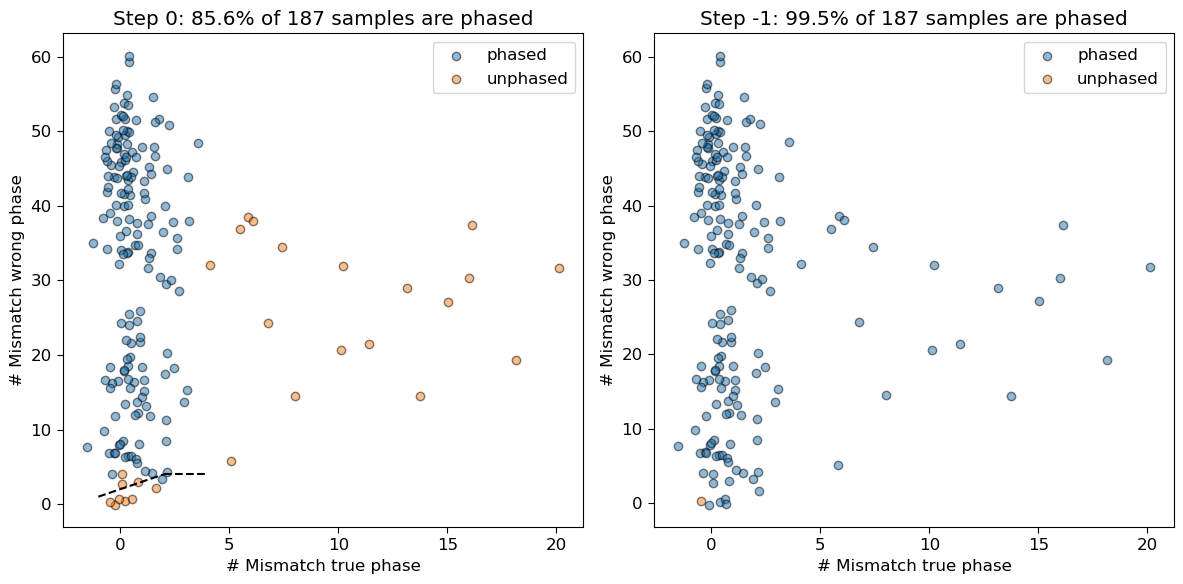

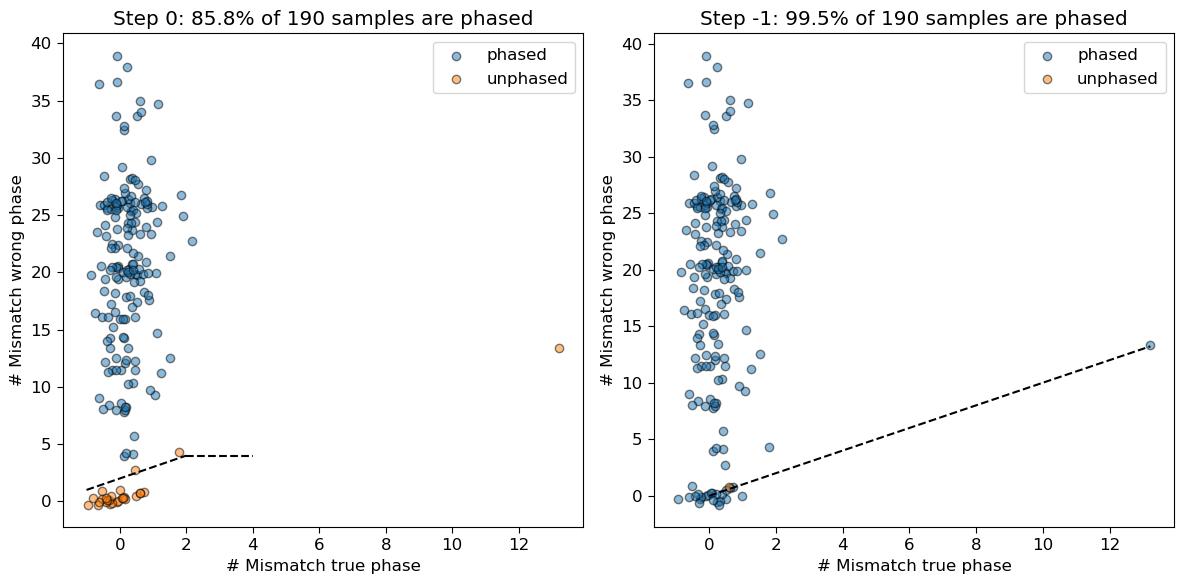

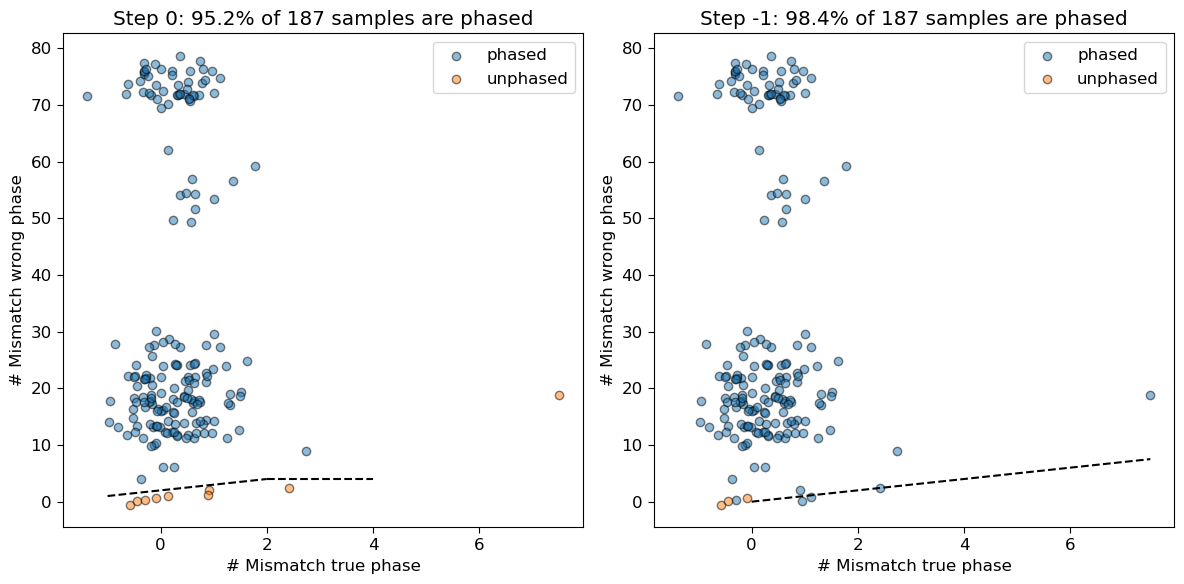

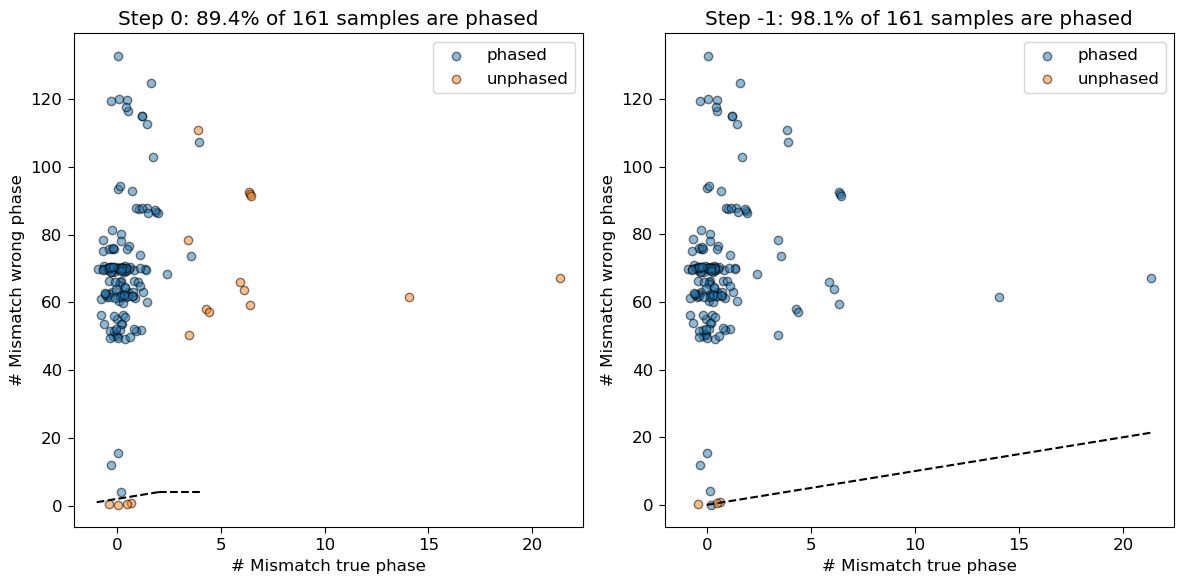

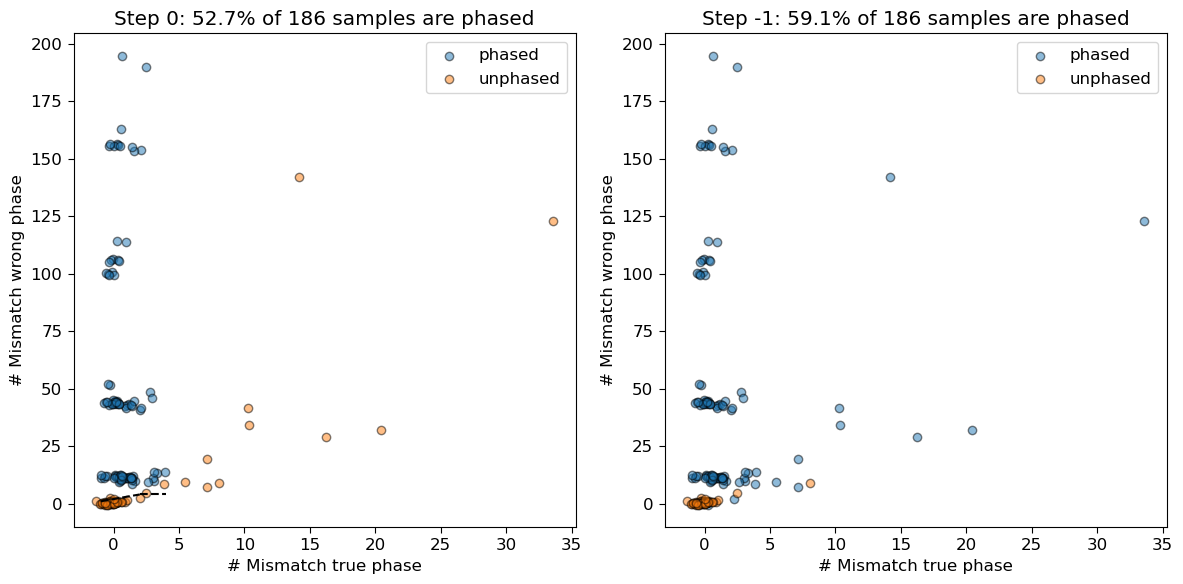

In [4]:
for gene, r in zip(HLA_GENES, return_dict_ary):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    plot_phase(r, 0, ax=axes[0], title = gene)
    plot_phase(r, -1, ax=axes[1], title = gene)

    plt.tight_layout()
    plt.show()

In [3]:
metrics

,Gene,Length,n_SNP,n_heterozygous,n_phased
0,A,2901,93,187,186
1,B,2675,79,190,189
2,C,2902,116,187,184
3,DQB1,6371,199,161,158
4,DRB1,10651,159,186,110


## GAMCC packed run

In [8]:
# For GAMCC
gene = 'DQB1'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3570/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/vcf/chr6.dose.vcf.gz"

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv(SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information, 
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            read_from_QUILT = False, 
                            subset_vcf_samples = subset_vcf_samples,
                            sample_linker = sample_linker)

## Reworking graphs

### Workspace

In [ ]:
gene = 'A'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3570/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/vcf/chr6.dose.vcf.gz"

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv(SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

return_dict_ary = []
metrics = pd.DataFrame(columns = ['Gene', 'Length', 'n_SNP', 'n_heterozygous', 'n_phased'])

return_dict = phase_hla_on_haplotypes(gene = gene, 
                                    ipd_gen_file_dir = ipd_gen_file_dir, 
                                    hla_gene_information = hla_gene_information, 
                                    hlatypes = hlatypes,
                                    phased_vcf = phased_vcf, 
                                    reference_allele_ary = reference_allele_ary, 
                                    read_from_QUILT = False, 
                                    subset_vcf_samples = subset_vcf_samples,
                                    sample_linker = sample_linker)
        
return_dict_ary.append(return_dict)

ix = hla_gene_information[hla_gene_information['Name'] == f'HLA-{gene}'].index[0]
length = (hla_gene_information['End'] - hla_gene_information['Start']).loc[ix]
n_snp = len(return_dict['merged_snps'])
n_heterozygous = len(hlatypes[(hlatypes[f'HLA-{gene} 1'] != hlatypes[f'HLA-{gene} 2'])])
n_phased = n_heterozygous-len(return_dict['unphased_df'])

metrics.loc[len(metrics)] = [gene, length, n_snp, n_heterozygous, n_phased]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_phase(return_dict, 0, ax=axes[0], title = gene)
plot_phase(return_dict, -1, ax=axes[1], title = gene)

plt.tight_layout()
plt.show()

In [4]:
return_dict = return_dict_ary[3]
s = 'GAM547806'
ix = np.where(hlatypes['Sample ID'] == s)[0][0]
merged_snps = return_dict['merged_snps']
vcfallele1 = return_dict['vcfalleles1_ary'][0]
vcfallele2 = return_dict['vcfalleles2_ary'][0]
trueallele1 = return_dict['truealleles1_ary'][0]
trueallele2 = return_dict['truealleles2_ary'][0]
type1 = lcwgsus.retain_smallest_two_field(lcwgsus.merge_two_field(return_dict['reftypes1'][ix]))
type2 = lcwgsus.retain_smallest_two_field(lcwgsus.merge_two_field(return_dict['reftypes2'][ix]))
    
plot_phasing_bar_graph(s, ix, merged_snps, 
                       vcfallele1, vcfallele2, trueallele1, trueallele2, 
                       type1, type2, 20, 70)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
hlatypes

,Region,Population,Sample ID,HLA-A 1,HLA-A 2,HLA-B 1,HLA-B 2,HLA-C 1,HLA-C 2,HLA-DQB1 1,HLA-DQB1 2,HLA-DRB1 1,HLA-DRB1 2
0,EUR,GBR,HG00096,01:01,29:02,08:01,44:03,07:01,16:01,02:01,02:02,03:01,07:01
1,EUR,GBR,HG00097,03:01,24:02,07:02,07:02,07:02,07:02,03:01,06:02,13:03,15:01
2,EUR,GBR,HG00099,01:01,68:01,08:01,44:02,07:01,07:04,02:01,03:01,03:01,11:01
3,EUR,GBR,HG00100,01:01,01:01,08:01,57:01,06:02,07:01,02:01,03:03,03:01,07:01
4,EUR,GBR,HG00101,11:01,32:01,27:05,57:01,02:02,06:02,03:02,06:02,04:04,15:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688,SAS,GIH,NA21137,01:01,11:01,57:01,40:06,06:02,15:02,03:03,06:01,09:01,15:01
2689,SAS,GIH,NA21141,02:11,24:02,15:05,18:01,03:03,07:01,03:02/03,05:03,07:01,15:02
2690,SAS,GIH,NA21142,03:01,24:02,35:01,44:03,04:01,07:06,05:01,06:09,01:01,13:02
2691,SAS,GIH,NA21143,11:01,26:01,08:01,57:01,06:02,07:02,02:01,03:03,03:01,07:01


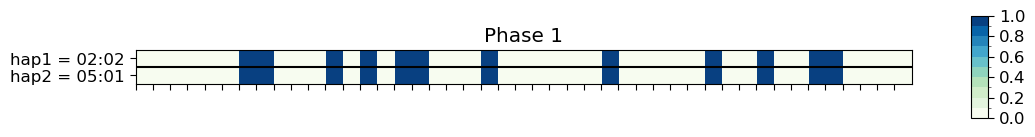

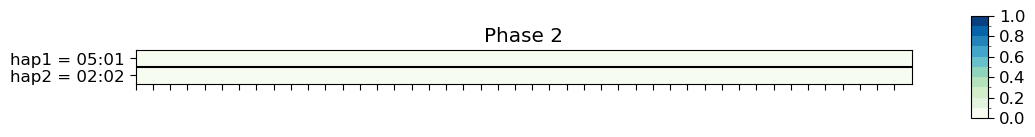

In [96]:
s = 'GAM547806'
ix = np.where(hlatypes['Sample ID'] == s)[0][0]
step = 1
merged_snps = return_dict['merged_snps']
vcfallele1 = return_dict['vcfalleles1_ary'][step]
vcfallele2 = return_dict['vcfalleles2_ary'][step]
trueallele1 = return_dict['truealleles1_ary'][step]
trueallele2 = return_dict['truealleles2_ary'][step]
type1 = lcwgsus.retain_smallest_two_field(lcwgsus.merge_two_field(return_dict['reftypes1'][ix]))
type2 = lcwgsus.retain_smallest_two_field(lcwgsus.merge_two_field(return_dict['reftypes2'][ix]))
    
plot_phasing_bar_graph(s, ix, merged_snps, 
                       vcfallele1, vcfallele2, trueallele1, trueallele2, 
                       type1, type2, 130, 175)

In [23]:
unphased_samples_to_remove = hlatypes.loc[indices, 'Sample ID'].tolist()
samples_to_remove = samples_to_remove + unphased_samples_to_remove

In [ ]:
# RETAIN THIS!
# gamcc_hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
# gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Included Alleles']]
# for s in gamcc_hla['SampleID'].unique():
#     tmps = gamcc_hla[gamcc_hla['SampleID'] == s]
#     for l in HLA_GENES:
#         tmpl = tmps[tmps['Locus'] == l]
#         repeat = 2 - tmpl.shape[0]
#         if repeat == 2:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#         if repeat == 1:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, tmpl.iloc[0,2]]
                
# gamcc_hla = gamcc_hla[gamcc_hla['Locus'] == gene]
# gamcc_hla = gamcc_hla[['SampleID', 'Included Alleles']]

# gamcc_hla = pd.merge(gamcc_hla[::2], gamcc_hla[1::2], on = 'SampleID')
# gamcc_hla.columns = ['Sample ID', 'HLA-DRB1 1', 'HLA-DRB1 2']
# gamcc_hla

# x = gamcc_hla.iloc[0, 1]
# indices = []
# db_alleles = db.index.to_numpy()

# for a in x.split('/'):
#     old_a = a
#     while (gene + '*' + a) not in db.index and ':' in a:
#         a = a.rsplit(':', 1)[0]
#     if ':' in a:
#         indices.append(np.where(db_alleles == gene + '*' + a)[0][0])

# x = db.iloc[np.array(indices), :]

# Checking % of phasing in each region

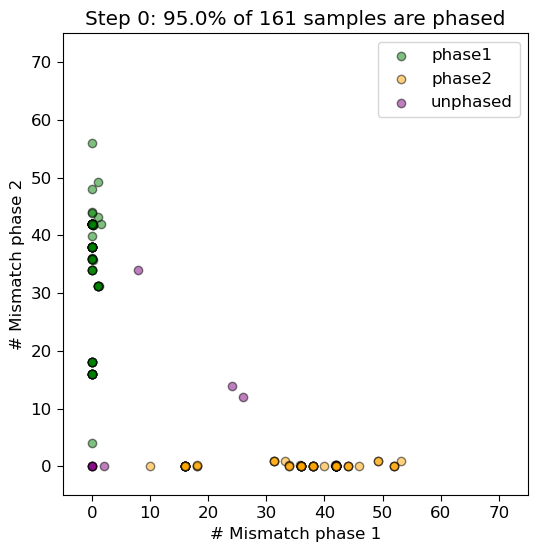

In [55]:
plot_phase(return_dict, 0)

## GAMCC

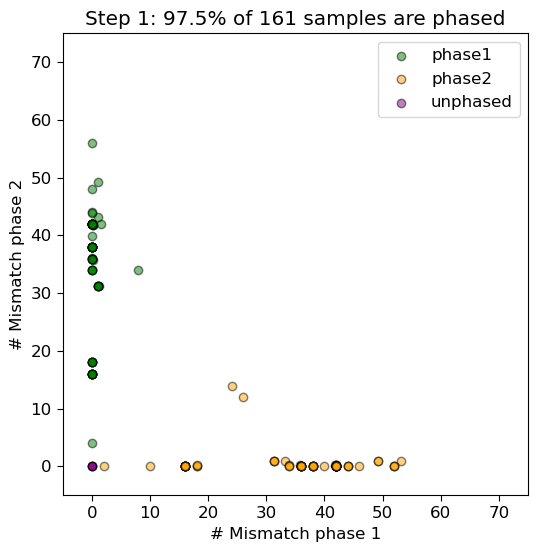

In [58]:
plot_phase(return_dict, 1)

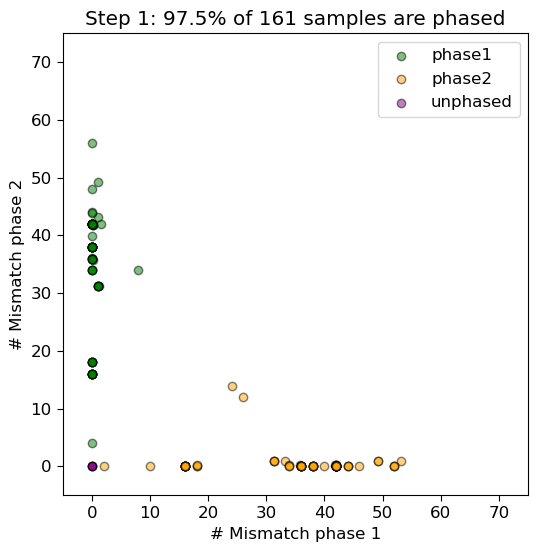

In [70]:
plot_phase(return_dict, 1)

### Other alleles

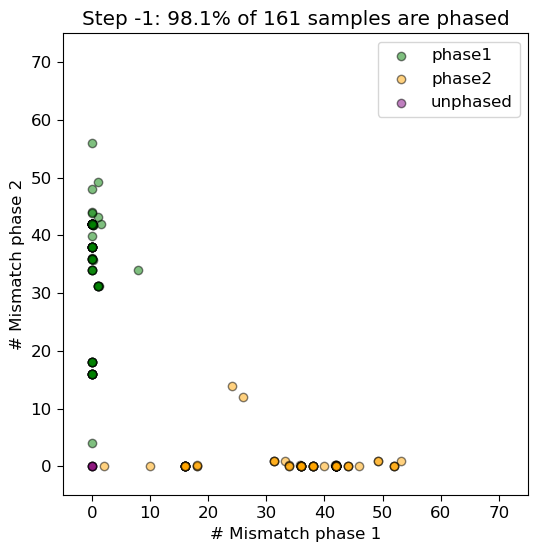

In [102]:
plot_phase(return_dict, -1)

In [38]:
# For GAMCC
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3390/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/vcf/chr6.dose.vcf.gz"

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv(SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

summary_gamcc = pd.DataFrame(columns = ['gene', '% sample unphased'])
for g in ['A', 'B', 'C', 'DQB1']:
    return_dict = phase_hla_on_haplotypes(gene = g, 
                                ipd_gen_file_dir = ipd_gen_file_dir, 
                                hla_gene_information = hla_gene_information, 
                                hlatypes = hlatypes,
                                phased_vcf = phased_vcf, 
                                reference_allele_ary = reference_allele_ary, 
                                read_from_QUILT = False, 
                                subset_vcf_samples = subset_vcf_samples,
                                sample_linker = sample_linker)
    
    summary_gamcc.loc[len(summary_gamcc)] = [g, return_dict['unphased_df'].shape[0]*100/210]
summary_gamcc

,gene,% sample unphased
0,A,0.057143
1,B,0.014286
2,C,0.023810
3,DQB1,0.014286


### DRB1

In [34]:
gene = 'DRB1'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
phased_vcf = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz"

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv(SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

summary_gamcc = pd.DataFrame(columns = ['gene', '% sample unphased'])
return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information, 
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            strict_snp_filter = False,
                            read_from_QUILT = True, 
                            subset_vcf_samples = subset_vcf_samples,
                            sample_linker = sample_linker)
    
# summary_gamcc.loc[4,:] = ['DRB1', return_dict['unphased_df'].shape[0]/210]
return_dict['unphased_df'].shape[0]/210

0.05238095238095238

In [42]:
# summary_gamcc.loc[len(summary_gamcc)] = ['DRB1', 0.05238]
# summary_gamcc['% sample unphased'] = summary_gamcc['% sample unphased']*100
summary_gamcc

,gene,% sample unphased
0,A,5.714286
1,B,1.428571
2,C,2.380952
3,DQB1,1.428571
4,DRB1,5.238000


## oneKG

In [8]:
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')

ref_samples = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/oneKG.samples', sep = ' ')
hlatypes = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG_30x/oneKG.chr6.vcf.gz"
reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))

summary_oneKG = pd.DataFrame(columns = ['gene', '% sample unphased'])
for g in HLA_GENES:
    return_dict = phase_hla_on_haplotypes(gene = g, 
                                ipd_gen_file_dir = ipd_gen_file_dir, 
                                hla_gene_information = hla_gene_information,
                                hlatypes = hlatypes,
                                phased_vcf = phased_vcf, 
                                reference_allele_ary = reference_allele_ary, 
                                read_from_QUILT = False, 
                                subset_vcf_samples = None,
                                sample_linker = None)
    
    summary_oneKG.loc[len(summary_oneKG)] = [g, return_dict['unphased_df'].shape[0]*100/2568]
summary_oneKG

,gene,% sample phased
0,A,0.032321
1,B,0.015187
2,C,0.009735
3,DQB1,0.116433
4,DRB1,0.001558


In [51]:
summary = pd.merge(summary_oneKG, summary_gamcc, on = ['gene'], suffixes = ('_oneKG', '_gamcc'))
summary

,gene,% sample unphased_oneKG,% sample unphased_gamcc
0,A,3.232087,5.714286
1,B,1.518692,1.428571
2,C,0.973520,2.380952
3,DQB1,11.643302,1.428571
4,DRB1,0.155763,5.238000
